# Graph Convolutional Networks

The Graphical Convolutional Network (GCN) is a scalable approach presented by Kipf and Welling (2016) for semi-supervised learning on graph-structured data. It is based on a variant of convolutional neural networks that operate directly on graphs.

Similar to the convolution operation, convolution in GCNs involves the model learning features by examining neighbouring nodes. If we consider that CNNs are designed to operate on Euclidean structured data, GNNs can be considered the generalized version of CNNs, as they can handle varying numbers of node connections and unordered nodes on irregular or non-Euclidean structured data.

Given an undirected graph $\mathcal{G}$, Kipf and Welling (2016) proposed a multi-layer GCN that employs the following layer-wise propagation rule

$$
\textbf{H}^{(l)} = \sigma \left( \tilde{\textbf{D}}^{-\frac{1}{2}} \tilde{\textbf{A}} \tilde{\textbf{D}}^{-\frac{1}{2}} \textbf{H}^{(l-1)} \textbf{W}^{(l-1)} \right)
$$

and the definition of the spectral convolution of a signal $x$ with a filter $g_{\theta'}$ at each iteration $k \in K$

$$
g_{\theta'} \star x \approx \sum^K_{k=0} \theta'_k T_k (\tilde{\textbf{L}})x
$$

where

- $\textbf{H}^{(l)}$ is the matrix of node representations at layer $l$
- $\sigma$ is the activation function
- $\textbf{W}$ is the trainable parameter matrix
- the Chebyshev polynomials are recursively defined as $T_k(x) = 2xT_{k-1}(x) - T_{k-2}(x)$
- $\theta' \in \mathbb{R}^K$ is a vector of Chebyshev coefficients
- given the identity matrix $\textbf{I}$ and the normalized graph Laplacian $\textbf{L}$
    - $\tilde{\textbf{A}} = \textbf{A} + \textbf{I}$ is the graph adjacency matrix with added self-connections
    - $\tilde{\textbf{D}}_{ii} = \sum_j \tilde{\textbf{A}} _{ij}$
    - $\tilde{\textbf{L}} = \frac{2}{\lambda_{\text{max}}}\textbf{L} - \textbf{I}$ (here $\lambda_{\text{max}}$ denotes the largest eigenvalue of $\textbf{L}$)

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from model.dgl.DGLModel import DGLModel
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [ ]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[64], [64, 64], [64, 128], [64, 128, 256]]),
    "gnn_norm": tune.choice(["right", "both", "none"]),
    "residual": tune.choice([True, False]),
    "batchnorm": tune.choice([True, False]),
    "dropout": tune.uniform(0, 1),
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "weight_decay": tune.uniform(0, 0.5),
    "epoch": tune.choice([100, 200, 300])
}

In [ ]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=config["hidden_feats"],
        gnn_norm=config["gnn_norm"],
        activation=relu,
        residual=config["residual"],
        batchnorm=config["batchnorm"],
        dropout=config["dropout"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # General DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False,
        device=torch.device("cpu")
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [ ]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=10),
    dataset=TRN
)
tune_result = tuner.fit()

In [ ]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

In [ ]:
MODEL = GCN(
    task_type="regression",
    # GCN Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=best_result.config["hidden_feats"],
    gnn_norm=best_result.config["gnn_norm"],
    activation=relu,
    residual=best_result.config["residual"],
    batchnorm=best_result.config["batchnorm"],
    dropout=best_result.config["dropout"],
    classifier_hidden_feats=128,
    classifier_dropout=0,
    predictor_hidden_feats=128,
    predictor_dropout=0,
    # Abstract DGL Configuration
    lr=best_result.config["lr"],
    y_name="LogS exp (mol/L)",
    weight_decay=best_result.config["weight_decay"],
    batch_size=4096
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=best_result.config["epoch"])

In [ ]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [ ]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=best_result.config["epoch"],
    extra_eval_set=TST,
    cv=5,
    verbose=True
)

In [ ]:
print(f"TST : RMSE {mean_squared_error(TST.y, MODEL.predict(TST).cpu(), squared=False)}")

In [ ]:
def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm='both',
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=config["dropout"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # General DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False,
        device=torch.device("cpu")
    )
    scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [ ]:
SPACE = {
    'dropout': tune.uniform(0, 0.35),
    'weight_decay': tune.uniform(0, 0.01),
    'epoch': tune.uniform(10, 500)
}

In [ ]:
from ray.tune.search.bayesopt import BayesOptSearch

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=BayesOptSearch(metric="rmse", mode="min"),
    dataset=TRN
)
tune_result = tuner.fit()

In [4]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [5]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [45]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu

AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm="both",
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=0.13108904159657686,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.007319939418114051,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=800, min_epoch=300, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 325/800 [00:21<00:31, 15.10it/s, loss: 0.101 rmse: 1.085]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 329/800 [00:21<00:30, 15.35it/s, loss: 0.110 rmse: 0.765]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 328/800 [00:21<00:31, 14.95it/s, loss: 0.106 rmse: 0.765]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 40%|████      | 322/800 [00:19<00:29, 16.23it/s, loss: 0.111 rmse: 1.299]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 43%|████▎     | 344/800 [00:20<00:26, 16.95it/s, loss: 0.131 rmse: 1.103]


In [46]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [47]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.670786488708243
TST : R^2 0.7557460603618242


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (GCN)\nRMSE: 0.671, $R^2$: 0.756')

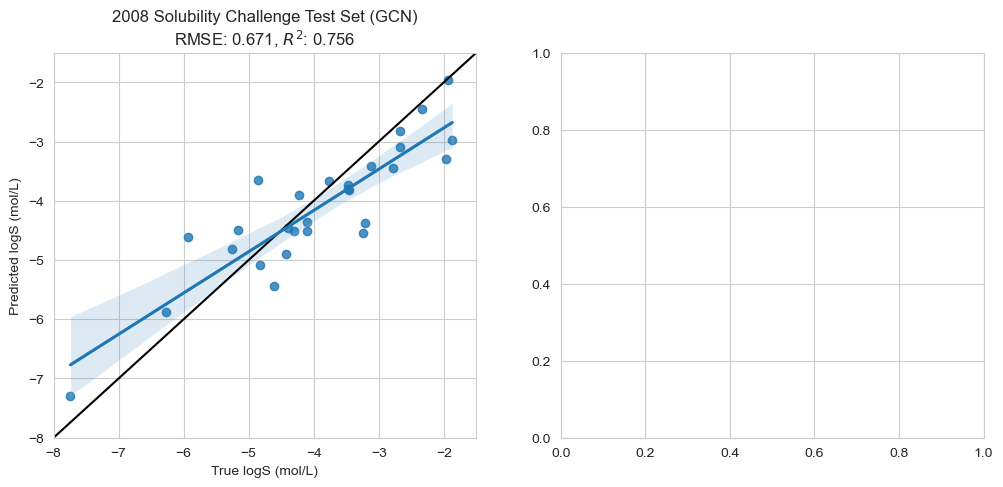

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")

In [49]:
TRN = Dataset.load_csv("ds/08SC/TRN")
TST = Dataset.load_csv("ds/TST")

In [50]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [51]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [55]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu

AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm="both",
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=0.13108904159657686,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.007319939418114051,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=800, min_epoch=400, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 57%|█████▋    | 459/800 [00:16<00:12, 27.48it/s, loss: 0.019 rmse: 2.493]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 54%|█████▍    | 435/800 [00:15<00:12, 28.35it/s, loss: 0.030 rmse: 1.458]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 56%|█████▌    | 448/800 [00:16<00:12, 27.26it/s, loss: 0.019 rmse: 0.758]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 56%|█████▋    | 451/800 [00:16<00:12, 27.56it/s, loss: 0.019 rmse: 1.155]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 55%|█████▍    | 437/800 [00:16<00:13, 27.17it/s, loss: 0.024 rmse: 1.794]


In [56]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [57]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 1.1626021687845336
TST : R^2 0.2662717808575559
